# Proposed Ideal 5 Neuron Network

In this two neurons together form the trigger. They then trigger a go neuron. This activating gets copied across to a new reset neuron, and

In [222]:
# Okay, let's have a look at what the oscillator networks are doing
import torch
import parameters_will
import torch.optim as optim
import RNN_Will as _model_
import numpy as np
import matplotlib.pyplot as plt
import pickle
import utils
import copy

%load_ext autoreload
%autoreload 2

params = parameters_will.default_params()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
params.model.h_size = 5
model = _model_.Oscillator(params.model)

out_weights = np.zeros([params.model.h_size])
out_bias = np.zeros([1])
hidden_init = np.zeros([params.model.h_size])
hidden_biases = np.zeros([params.model.h_size])
hidden_weights = np.zeros([params.model.h_size, params.model.h_size])

# Make only the trigger send output
out_weights[:] = 0
out_weights[2] = 2
out_bias[:] = -1

# Then set up the recurrent connectivity
hidden_weights[:,:] = 0
hidden_biases[2] = 1 # First the size of the middle neuron activaction
hidden_biases[3] = -10

# Trigger neurons outwards
hidden_weights[4, 2] = 1
hidden_weights[3, 2] = 10
hidden_weights[2, 2] = -10
hidden_weights[1, 2] = -10
hidden_weights[0, 2] = -10

# Timer and storage, or storage and trigger interactions
hidden_weights[1, 4] = 3
hidden_weights[0, 3] = 1
hidden_weights[3, 0] = 1
hidden_weights[2, 4] = -1

# Timer, and timer to trigger
hidden_weights[1, 0] = -0.5
hidden_weights[2, 1] = -30
hidden_weights[0,0] = 1
hidden_weights[1,1] = 1

# Finially intialise the clock correctly
hidden_init[0] = 0.9
hidden_init[1] = 1

model.predict.state_dict()['weight'][0,:] = torch.tensor(out_weights)
model.predict.state_dict()['bias'] = torch.tensor(out_bias)
model.transition.state_dict()['weight'] = torch.tensor(hidden_weights)
model.transition.state_dict()['bias'] = torch.tensor(hidden_biases)
model.hidden_init = torch.nn.Parameter(torch.tensor(hidden_init, requires_grad = False))

network_setup = parameters_will.DotDict({
    'hw': hidden_weights,
    'hb': hidden_biases,
    'ow': out_weights,
    'ob': out_bias,
    'hi': hidden_init})

In [275]:
def ReLU(x):
    return np.maximum(np.zeros(x.shape), x)

def forward(network_setup, T):
    num_neurons = np.size(network_setup.hi)
    pres = np.zeros([T, num_neurons])
    hs = np.zeros([T, num_neurons])
    preds = np.zeros([T])
    
    pres[0,:] = network_setup.hi
    hs[0,:] = ReLU(pres[0,:])
    preds[0] = np.matmul(network_setup.ow, hs[0,:])
    
    for t in range(1,T):
        pres[t,:] = np.matmul(network_setup.hw, hs[t-1,:]) + network_setup.hb
        hs[t,:] = ReLU(pres[t,:])
        preds[t] = np.matmul(network_setup.ow, hs[t,:])
        
    values = parameters_will.DotDict({
        'pres': pres,
        'hs': hs,
        'preds': preds})
    return values

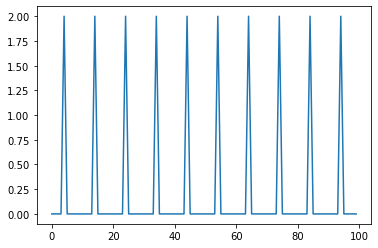

In [276]:
values = forward(network_setup, 100)
plt.plot(values.preds)

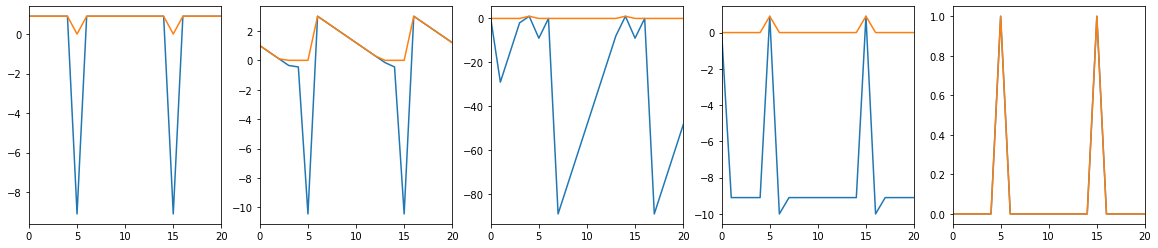

In [278]:
plt.figure(figsize = (20, 4))
for neuron in range(5):
    plt.subplot(1, 5, neuron+1)
    plt.plot(values.pres[:,neuron])
    plt.plot(values.hs[:,neuron])
    plt.xlim([0, 20])

PROBLEM
1.2 11
[8 8 8 8 8 2]


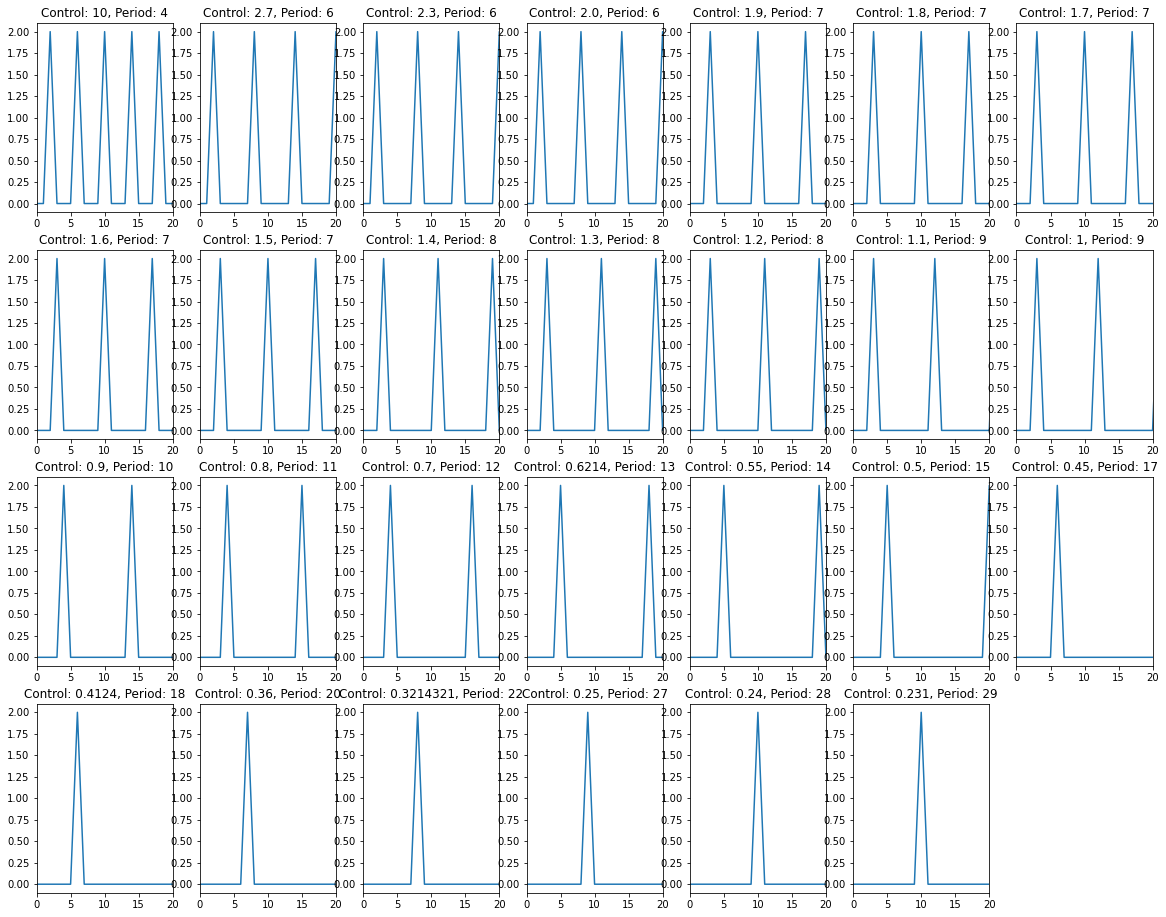

In [286]:
control_signals = [10,2.7,2.3,2.0,1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6214, 0.55, 0.5, 0.45, 0.4124, 0.36, 0.3214321, 0.25, 0.24, 0.231]
rows = 4
columns = int(np.ceil(len(control_signals)/rows))
outputs = []
hs = []
pres = []
plt.figure(figsize = (20, 4*rows))
for (control_i, control) in enumerate(control_signals):
    hidden_init[0] = control
    network_setup.hi = hidden_init 
    values = forward(network_setup, 1000)
    plt.subplot(rows,columns, control_i+1)
    plt.plot(values.preds)
    plt.xlim([0,20])
    differences = np.where(values.preds > 0.1)[0][1:] - np.where(values.preds > 0.1)[0][:-1]
    outputs.append(values.preds)
    if np.logical_not(np.all(differences == differences[0])) or differences[0] == 2:
        print('PROBLEM')
        print(control, control_i)
        hs.append(values.hs)
        pres.append(values.pres)
        print(differences)
        
    plt.title(f'Control: {control}, Period: {differences[0]}')

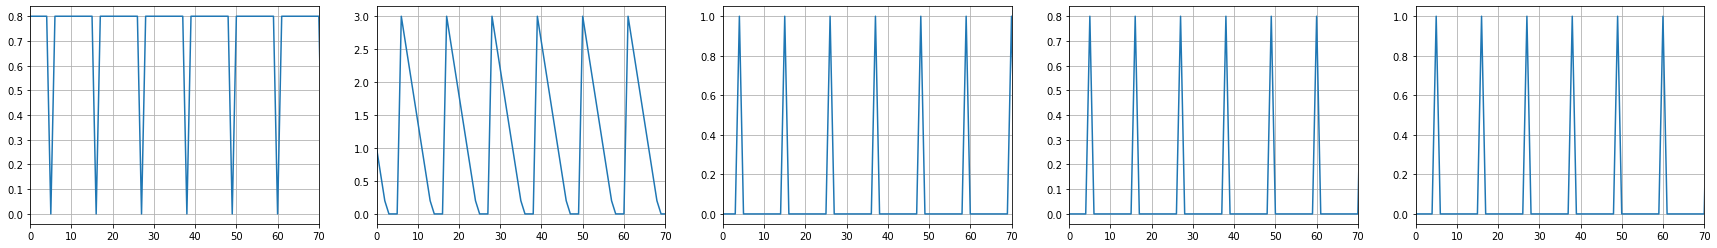

In [297]:
plt.figure(figsize = (30, 4))
for neuron in range(5):
    plt.subplot(1, 5, neuron+1)
    #plt.plot(values.pres[:,neuron])
    plt.plot(values.hs[:,neuron])
    plt.grid(visible=True)
    plt.xlim([0, 70])
    #plt.ylim([-10,10])

PROBLEM
0.7444444444444445 4
[11  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2 

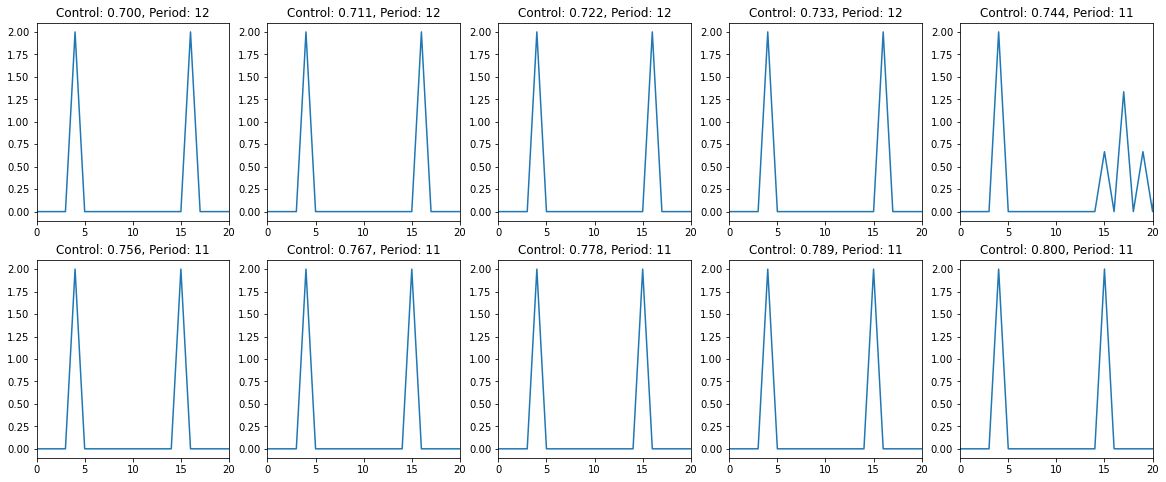

In [290]:
control_signals = np.linspace(0.7, 0.8, 10)
rows = 2
columns = int(np.ceil(len(control_signals)/rows))
outputs = []
hs = []
pres = []
plt.figure(figsize = (20, 4*rows))
for (control_i, control) in enumerate(control_signals):
    hidden_init[0] = control
    network_setup.hi = hidden_init 
    values = forward(network_setup, 1000)
    plt.subplot(rows,columns, control_i+1)
    plt.plot(values.preds)
    plt.xlim([0,20])
    differences = np.where(values.preds > 0.1)[0][1:] - np.where(values.preds > 0.1)[0][:-1]
    outputs.append(values.preds)
    if np.logical_not(np.all(differences == differences[0])) or differences[0] == 2:
        print('PROBLEM')
        print(control, control_i)
        hs.append(values.hs)
        pres.append(values.pres)
        print(differences)
        
    plt.title(f'Control: {control:.3f}, Period: {differences[0]}')

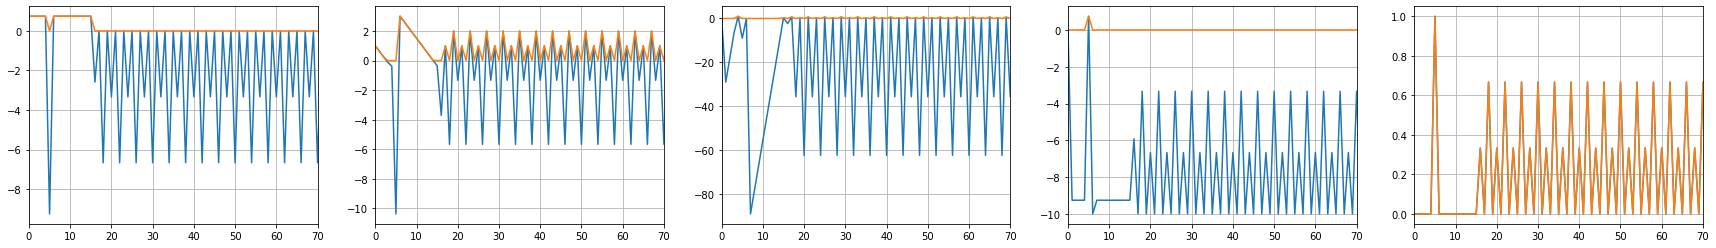

In [292]:
num_failures = len(hs)
plt.figure(figsize = (30, 4*num_failures))
for failure in range(num_failures):
    for neuron in range(5):
        plt.subplot(num_failures, 5, neuron+1+failure*5)
        plt.plot(pres[failure][:,neuron])
        plt.plot(hs[failure][:,neuron])
        plt.grid(visible=True)
        plt.xlim([0, 70])
        #plt.ylim([-10,10])

In [293]:
hs[0][:,1]

array([1.        , 0.62777778, 0.25555556, 0.        , 0.        ,
       0.        , 3.        , 2.62777778, 2.25555556, 1.88333333,
       1.51111111, 1.13888889, 0.76666667, 0.39444444, 0.02222222,
       0.        , 0.        , 1.        , 0.        , 2.        ,
       0.        , 1.        , 0.        , 2.        , 0.        ,
       1.        , 0.        , 2.        , 0.        , 1.        ,
       0.        , 2.        , 0.        , 1.        , 0.        ,
       2.        , 0.        , 1.        , 0.        , 2.        ,
       0.        , 1.        , 0.        , 2.        , 0.        ,
       1.        , 0.        , 2.        , 0.        , 1.        ,
       0.        , 2.        , 0.        , 1.        , 0.        ,
       2.        , 0.        , 1.        , 0.        , 2.        ,
       0.        , 1.        , 0.        , 2.        , 0.        ,
       1.        , 0.        , 2.        , 0.        , 1.        ,
       0.        , 2.        , 0.        , 1.        , 0.     

# Take two, to try and fix the errors!

We encourage the timer neuron to truly plummet

In [219]:
params.model.h_size = 6
model = _model_.Oscillator(params.model)

out_weights = np.zeros([params.model.h_size])
out_bias = np.zeros([1])
hidden_init = np.zeros([params.model.h_size])
hidden_biases = np.zeros([params.model.h_size])
hidden_weights = np.zeros([params.model.h_size, params.model.h_size])

# Make only the trigger send output
out_weights[:] = 0
out_weights[2] = 2
out_bias[:] = -1

# Then set up the recurrent connectivity
hidden_weights[:,:] = 0
hidden_biases[2] = 1 # First the size of the middle neuron activaction
hidden_biases[3] = -2
hidden_biases[5] = 1

# Trigger neurons outwards
hidden_weights[4, 2] = 1
hidden_weights[3, 2] = 2
hidden_weights[2, 2] = -10
hidden_weights[1, 2] = -10
hidden_weights[0, 2] = -10

# Timer and storage, or storage and trigger interactions
hidden_weights[1, 4] = 3
hidden_weights[0, 3] = 1
hidden_weights[3, 0] = 1
hidden_weights[2, 4] = -1

# Timer, and timer to trigger
hidden_weights[1, 0] = -0.5
hidden_weights[2, 1] = -10
hidden_weights[0,0] = 1
hidden_weights[1,1] = 1
hidden_weights[5,1] = -5
hidden_weights[1,5] = -10
hidden_weights[5,5] = -10
hidden_weights[5,2] = -10
hidden_weights[5,4] = -10

# Finially intialise the clock correctly
hidden_init[0] = 0.9
hidden_init[1] = 1

model.predict.state_dict()['weight'][0,:] = torch.tensor(out_weights)
model.predict.state_dict()['bias'] = torch.tensor(out_bias)
model.transition.state_dict()['weight'] = torch.tensor(hidden_weights)
model.transition.state_dict()['bias'] = torch.tensor(hidden_biases)
model.hidden_init = torch.nn.Parameter(torch.tensor(hidden_init, requires_grad = False))

network_setup = parameters_will.DotDict({
    'hw': hidden_weights,
    'hb': hidden_biases,
    'ow': out_weights,
    'ob': out_bias,
    'hi': hidden_init})

PROBLEM
1.9 0
PROBLEM
0.6 13
PROBLEM
0.45 16
PROBLEM
0.4 17
PROBLEM
0.35 18
PROBLEM
0.3 19
PROBLEM
0.24 21


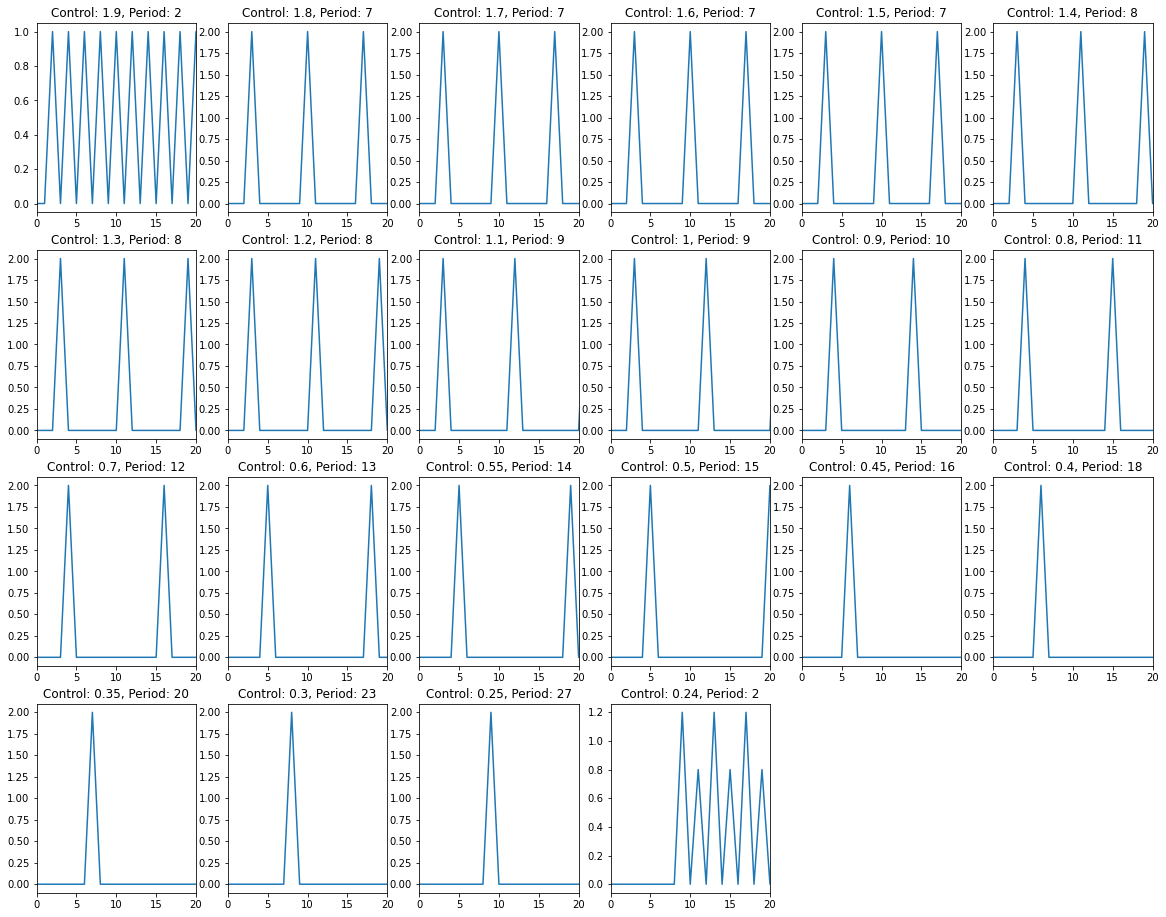

In [220]:
control_signals = [1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.24]
rows = 4
columns = int(np.ceil(len(control_signals)/rows))
outputs = []
hs = []
pres = []
plt.figure(figsize = (20, 4*rows))
for (control_i, control) in enumerate(control_signals):
    hidden_init[0] = control
    network_setup.hi = hidden_init 
    values = forward(network_setup, 200)
    plt.subplot(rows,columns, control_i+1)
    plt.plot(values.preds)
    plt.xlim([0,20])
    differences = np.where(values.preds > 0.1)[0][1:] - np.where(values.preds > 0.1)[0][:-1]
    outputs.append(values.preds)
    if np.logical_not(np.all(differences == differences[0])) or differences[0] == 2:
        print('PROBLEM')
        print(control, control_i)
        hs.append(values.hs)
        pres.append(values.pres)
        
    plt.title(f'Control: {control}, Period: {differences[0]}')

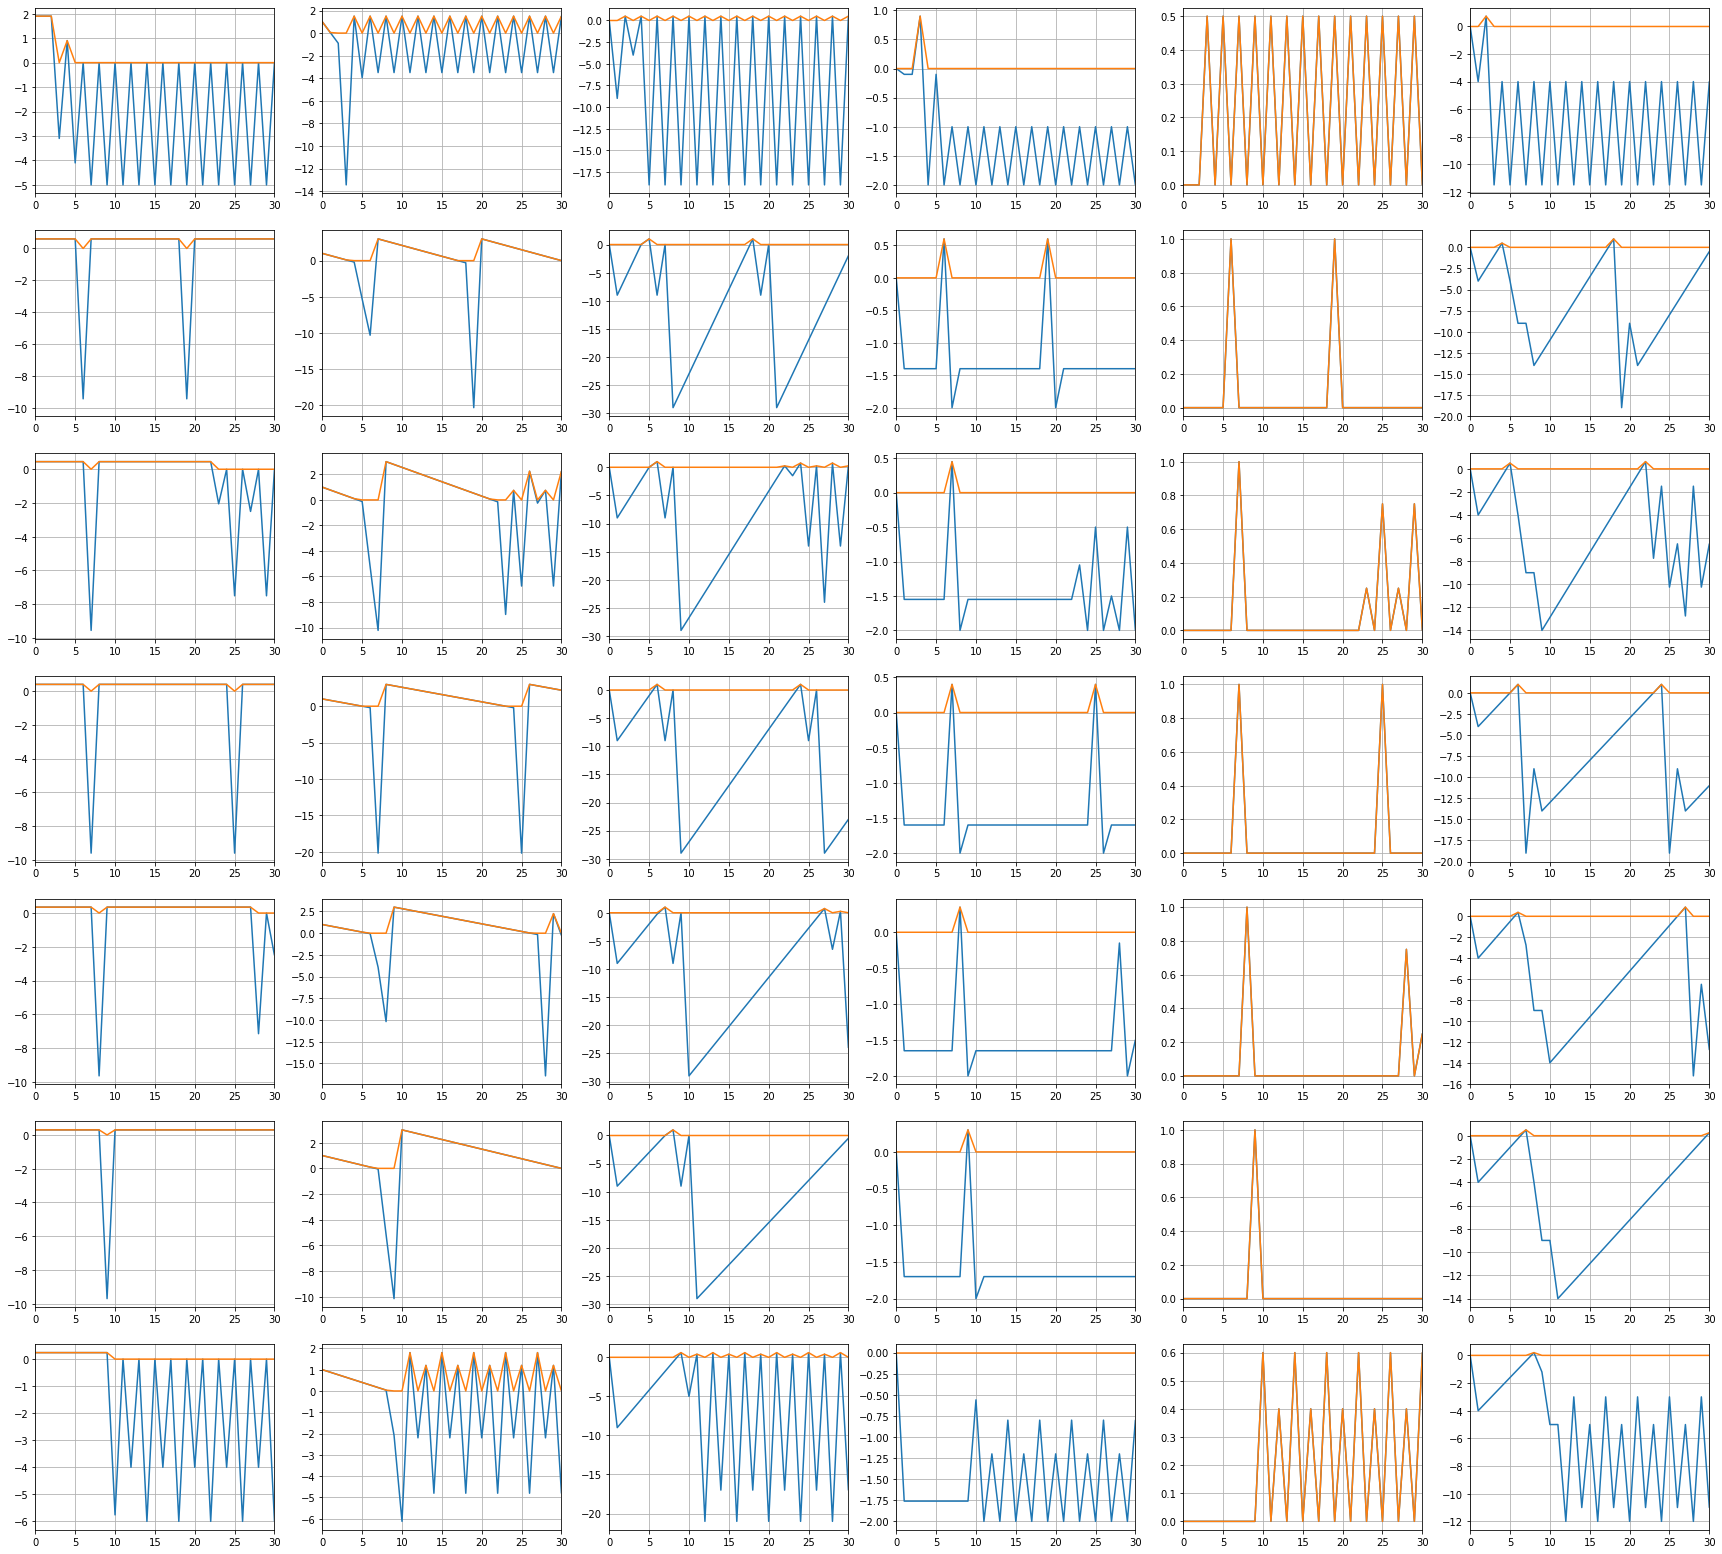

In [221]:
num_failures = len(hs)
plt.figure(figsize = (30, 4*num_failures))
for failure in range(num_failures):
    for neuron in range(params.model.h_size):
        plt.subplot(num_failures, params.model.h_size, neuron+1+failure*params.model.h_size)
        plt.plot(pres[failure][:,neuron])
        plt.plot(hs[failure][:,neuron])
        plt.grid(visible=True)
        plt.xlim([0, 30])